In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score
import lightgbm as lgb

In [2]:
from sklearn.decomposition import PCA

In [4]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print(dir(config))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'data_path', 'feature_dict', 'feature_path', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']


In [5]:
config.feature_dict

{'login_trade_hist_stats': ['after_fail_max_1',
  'after_fail_max_15',
  'after_fail_max_3',
  'after_fail_max_30',
  'after_fail_max_360',
  'after_fail_max_7',
  'after_fail_mean_1',
  'after_fail_mean_15',
  'after_fail_mean_3',
  'after_fail_mean_30',
  'after_fail_mean_360',
  'after_fail_mean_7',
  'after_fail_med_1',
  'after_fail_med_15',
  'after_fail_med_3',
  'after_fail_med_30',
  'after_fail_med_360',
  'after_fail_med_7',
  'after_fail_min_1',
  'after_fail_min_15',
  'after_fail_min_3',
  'after_fail_min_30',
  'after_fail_min_360',
  'after_fail_min_7',
  'after_fail_std_1',
  'after_fail_std_15',
  'after_fail_std_3',
  'after_fail_std_30',
  'after_fail_std_360',
  'after_fail_std_7',
  'login_fail_times_1',
  'login_fail_times_15',
  'login_fail_times_3',
  'login_fail_times_30',
  'login_fail_times_360',
  'login_fail_times_7',
  'login_success_rate_1',
  'login_success_rate_15',
  'login_success_rate_3',
  'login_success_rate_30',
  'login_success_rate_360',
  'log

In [7]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats'])
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))

In [9]:
for i in range(len(feature_sequence_list)):
    if feature_sequence_list[i].shape != feature_sequence_list[0].shape:
        print(features[i],feature_sequence_list[i].shape)
trade_tt_mat = np.hstack(feature_sequence_list)

### Validation via GBM model

In [10]:
#model define

def f_beta_01(preds, train_data):
    labels  = train_data.get_label()
    return 'fbeta_score_01',fbeta_score(labels, preds > 0.5,0.1),True

    
#for binary
def runLGBM(train_X, train_y, test_X, test_y=None, feature_names=None,
           seed_val=0, num_rounds=10000,watch_dict = None,max_bin=50000,
           num_leaves=16,early_stop=64,verbose=True,eta=0.1,
           bagging_fraction = 0.75 , feature_fraction = 0.75,feval = None,metric = 'binary_logloss',
           train_sample_weight = None):
    
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': num_leaves,
        'learning_rate': eta,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': 5,
        'verbose': verbose,
        'is_unbalance':False
    }
    
    num_rounds = num_rounds

    #plst = list(param.items())
    lgbtrain = lgb.Dataset(train_X, label=train_y,max_bin=max_bin,feature_name=feature_names,weight =train_sample_weight)

    if test_y is not None:
        lgbtest = lgb.Dataset(test_X, label=test_y,max_bin=max_bin,feature_name=feature_names)
        watchlist = [lgbtrain,lgbtest]
        watchlist_name=['train','test']
        model = lgb.train(params, lgbtrain, num_rounds, watchlist,watchlist_name, early_stopping_rounds=early_stop,\
                         evals_result = watch_dict,verbose_eval=verbose,feval = feval)
    else:
        #lgbtest = lgb.Dataset(test_X,feature_name=feature_names)
        model = lgb.train(params, lgbtrain, num_rounds)

    pred_test_y = model.predict(test_X)
    return pred_test_y, model

In [12]:
validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

In [14]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.93919	test's auc: 0.922661
[200]	train's auc: 0.97702	test's auc: 0.959978
[300]	train's auc: 0.992494	test's auc: 0.967505
[400]	train's auc: 0.997036	test's auc: 0.967873
[500]	train's auc: 0.998632	test's auc: 0.967099
Early stopping, best iteration is:
[411]	train's auc: 0.997187	test's auc: 0.968222
f_beta score for the turn 1 is 0.823529411765
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.95801	test's auc: 0.846613
[200]	train's auc: 0.983573	test's auc: 0.886538
[300]	train's auc: 0.99384	test's auc: 0.901938
[400]	train's auc: 0.998148	test's auc: 0.909854
[500]	train's auc: 0.999164	test's auc: 0.912912
Early stopping, best iteration is:
[495]	train's auc: 0.999138	test's auc: 0.91367
f_beta score for the turn 2 is 0.36685584563
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.949772	test's auc: 0.919627
[200]	train's auc:

### 尝试使用取消使用-10对np.nan的填充

In [16]:
trade_tt_mat_with_NA = trade_tt_mat
trade_tt_mat_with_NA[trade_tt_mat_with_NA==-10]=np.nan


cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat_with_NA[train_indice], trade_tt_mat_with_NA[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.945878	test's auc: 0.931352
[200]	train's auc: 0.976898	test's auc: 0.959542
[300]	train's auc: 0.992755	test's auc: 0.96718
[400]	train's auc: 0.996926	test's auc: 0.968233
Early stopping, best iteration is:
[358]	train's auc: 0.995888	test's auc: 0.968809
f_beta score for the turn 1 is 0.829843625762
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.959529	test's auc: 0.85979
[200]	train's auc: 0.98352	test's auc: 0.884438
[300]	train's auc: 0.994636	test's auc: 0.903044
[400]	train's auc: 0.998366	test's auc: 0.912637
[500]	train's auc: 0.999278	test's auc: 0.916982
[600]	train's auc: 0.999688	test's auc: 0.917708
[700]	train's auc: 0.999871	test's auc: 0.918058
Early stopping, best iteration is:
[659]	train's auc: 0.999822	test's auc: 0.919654
f_beta score for the turn 2 is 0.37537746806
Training until validation scores don't improve for 100 rounds.
[100]	train's au

### check basic model importance

In [17]:
feature_importance_total = np.zeros(176)
for model in models:
    feature_importance_total+=model.feature_importance('gain')
sorted_feature_importacne = sorted(zip(features,feature_importance_total),key = lambda x : x[1],reverse = True)

In [18]:
sorted_feature_importacne

[('login_distance_0', 59223.424537617204),
 ('type_login_0', 23794.921317119552),
 ('login_distance_1', 20870.283181648574),
 ('trade_login_success_rate_1', 19317.561688541751),
 ('trade_times_1', 18997.744010064289),
 ('trade_login_rate_1', 17805.561171391761),
 ('trade_times_360', 17048.483074551063),
 ('login_success_rate_360', 16021.519821167383),
 ('login_success_rate_30', 14350.744728325808),
 ('timelong_std_1', 13696.724039177499),
 ('timelong_min_30', 13296.791676022744),
 ('login_success_times_360', 13190.676552805899),
 ('timelong_min_15', 11219.898247384339),
 ('type_login_1', 10520.893633008511),
 ('hour_login_2', 9929.3690999721111),
 ('hour_login_0', 9619.492702716565),
 ('timelong_max_1', 9449.6609686912961),
 ('login_distance_2', 9325.3054719801185),
 ('timelong_std_3', 8606.6309386399371),
 ('timelong_med_360', 7642.8078753582231),
 ('device_comparing_login_1', 6856.0971432348952),
 ('login_times_360', 6819.9994565205343),
 ('trade_login_fail_rate_360', 6716.3358915877

<Container object of 176 artists>

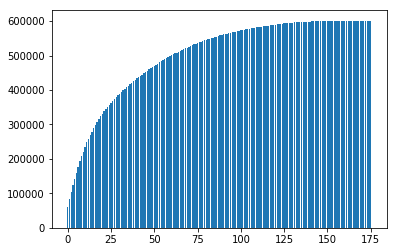

In [19]:
%matplotlib inline
all_importance = [x[1] for x in sorted_feature_importacne]
x = pd.Series(all_importance).sort_values(ascending = False).cumsum()
plt.bar(range(len(x)),x)

可以考虑在100~120处进行特征截断

### 增加feval作为参考量

In [20]:
trade_tt_mat_with_NA = trade_tt_mat
trade_tt_mat_with_NA[trade_tt_mat_with_NA==-10]=np.nan


cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat_with_NA[train_indice], trade_tt_mat_with_NA[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = f_beta_01)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.945878	train's fbeta_score_01: 0.945993	test's auc: 0.931352	test's fbeta_score_01: 0.834592
[200]	train's auc: 0.976898	train's fbeta_score_01: 0.943116	test's auc: 0.959542	test's fbeta_score_01: 0.834041
Early stopping, best iteration is:
[125]	train's auc: 0.957666	train's fbeta_score_01: 0.948297	test's auc: 0.946622	test's fbeta_score_01: 0.854527
f_beta score for the turn 1 is 0.854527086753
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.959529	train's fbeta_score_01: 0.931692	test's auc: 0.85979	test's fbeta_score_01: 0.143772
Early stopping, best iteration is:
[23]	train's auc: 0.943696	train's fbeta_score_01: 0.893504	test's auc: 0.807732	test's fbeta_score_01: 0.212073
f_beta score for the turn 2 is 0.212073490814
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.958854	train's fbeta_score_01: 0.96336	test's auc: 0.923541	

### 100 or 120 top features

In [25]:
top_100_features =  [x[0] for x in sorted_feature_importacne][0:100]
top_120_features = [x[0] for x in sorted_feature_importacne][0:120]

In [28]:
top_100_feature_ori_index = [features.index(x) for x in top_100_features]
top_120_feature_ori_index = [features.index(x) for x in top_120_features]

trade_tt_mat_top_100 = trade_tt_mat[:,top_100_feature_ori_index]
trade_tt_mat_top_120 = trade_tt_mat[:,top_120_feature_ori_index]

In [29]:
#top 100 features
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat_top_100[train_indice], trade_tt_mat_top_100[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_100_features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print'f_beta score for the turn '+str(i)+' is '+str(result_f_beta)

print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.945752	test's auc: 0.930972
[200]	train's auc: 0.975861	test's auc: 0.962274
[300]	train's auc: 0.991401	test's auc: 0.968582
[400]	train's auc: 0.996859	test's auc: 0.970153
Early stopping, best iteration is:
[369]	train's auc: 0.995713	test's auc: 0.970659
f_beta score for the turn 1 is 0.841743749428
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.960797	test's auc: 0.849681
[200]	train's auc: 0.983036	test's auc: 0.887895
[300]	train's auc: 0.994592	test's auc: 0.898921
[400]	train's auc: 0.99814	test's auc: 0.905889
[500]	train's auc: 0.999076	test's auc: 0.910468
[600]	train's auc: 0.999713	test's auc: 0.911916
[700]	train's auc: 0.999884	test's auc: 0.912116
Early stopping, best iteration is:
[650]	train's auc: 0.999824	test's auc: 0.913811
f_beta score for the turn 2 is 0.36685584563
Training until validation scores don't improve for 100 rounds.
[100]	train's 

In [30]:
#top 120 features
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat_top_120[train_indice], trade_tt_mat_top_120[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_120_features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print'f_beta score for the turn '+str(i)+' is '+str(result_f_beta)

print 'The mean of the cv_scores is:'
print np.mean(cv_scores)

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.945648	test's auc: 0.931387
[200]	train's auc: 0.976171	test's auc: 0.959514
[300]	train's auc: 0.99255	test's auc: 0.967698
[400]	train's auc: 0.997048	test's auc: 0.969833
Early stopping, best iteration is:
[369]	train's auc: 0.996306	test's auc: 0.970137
f_beta score for the turn 1 is 0.843187881918
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.960166	test's auc: 0.853897
[200]	train's auc: 0.982984	test's auc: 0.881746
[300]	train's auc: 0.994375	test's auc: 0.899809
[400]	train's auc: 0.997928	test's auc: 0.90811
[500]	train's auc: 0.998999	test's auc: 0.912305
Early stopping, best iteration is:
[445]	train's auc: 0.998643	test's auc: 0.913362
f_beta score for the turn 2 is 0.369062119367
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.952487	test's auc: 0.922335
[200]	train's auc: 0.981645	test's auc: 0.93912
[300]	train's a

In [62]:
config.model_features = {}

In [26]:
config.model_features = {}
config.model_features['moded_C1_top100'] = top_100_features
config.model_features['moded_C1_top100'] = top_120_features

In [27]:
print(dir(config))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'data_path', 'feature_dict', 'feature_path', 'model_features', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']


In [29]:
pd.to_pickle(config,'config_py3.pkl')

### if new features are performed PCA 

In [31]:
ori_features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing'])
pca_features = config.feature_dict['login_trade_hist_stats']
ori_feature_sequence_list = []
pca_feature_sequence_list = []
for feature in ori_features:
    ori_feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
for feature in pca_features:
    pca_feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))

In [32]:
trade_tt_ori = np.hstack(ori_feature_sequence_list)
trade_tt_to_be_pca = np.hstack(pca_feature_sequence_list)

In [33]:
#fill the na values to be mean
trade_tt_to_be_pca[trade_tt_to_be_pca ==-10] = np.nan
trade_tt_to_be_pca[trade_tt_to_be_pca ==-np.inf] = -10
for i in range(trade_tt_to_be_pca.shape[1]):
    trade_tt_to_be_pca[np.isnan(trade_tt_to_be_pca[:,i]) ,i] = pd.Series(trade_tt_to_be_pca[:,i]).dropna().mean()

In [34]:
for i in range(trade_tt_to_be_pca.shape[1]):
    trade_tt_to_be_pca[np.isnan(trade_tt_to_be_pca[:,i]) ,i] = pd.Series(trade_tt_to_be_pca[:,i]).dropna().mean()

In [35]:
#try pca with all to find out explained_variance_ratio_ 
all_pca = PCA(whiten = True)
all_pca.fit(trade_tt_to_be_pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [39]:
np.sum(all_pca.explained_variance_ratio_[:30])

0.99987614009848413

In [41]:
#use 1~20 for the resulting
apply_pac = PCA(n_components = 20,whiten = True)
trade_tt_type_C_pca = apply_pac.fit_transform(trade_tt_to_be_pca)
print(trade_tt_type_C_pca.shape)

(150594, 20)


In [42]:
trade_tt_mat = np.hstack([trade_tt_ori,trade_tt_type_C_pca])

In [43]:
type_c_pca_feature_list = ['type_c_feature_pca_'+str(i) for i in range(20)] 
features = ori_features+type_c_pca_feature_list

In [45]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.944916	test's auc: 0.933217
[200]	train's auc: 0.976134	test's auc: 0.961169
[300]	train's auc: 0.992655	test's auc: 0.966874
[400]	train's auc: 0.996977	test's auc: 0.969016
[500]	train's auc: 0.998797	test's auc: 0.968704
Early stopping, best iteration is:
[412]	train's auc: 0.99731	test's auc: 0.969116
f_beta score for the turn 1 is 0.823975429504
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.95852	test's auc: 0.848728
[200]	train's auc: 0.981502	test's auc: 0.874395
[300]	train's auc: 0.993772	test's auc: 0.890274
[400]	train's auc: 0.998019	test's auc: 0.897983
[500]	train's auc: 0.999163	test's auc: 0.903644
[600]	train's auc: 0.999627	test's auc: 0.904776
Early stopping, best iteration is:
[562]	train's auc: 0.999497	test's auc: 0.905231
f_beta score for the turn 2 is 0.319853836784
Training until validation scores don't improve for 100 rounds.
[100]	train's 

In [59]:
feature_importance_total = np.zeros(82)
for model in models:
    feature_importance_total+=model.feature_importance('gain')
sorted_feature_importacne = sorted(zip(features,feature_importance_total),key = lambda x : x[1],reverse = True)

In [60]:
sorted_feature_importacne

[('login_distance_0', 75551.984028709499),
 ('type_c_feature_pca_15', 37090.739199137097),
 ('type_login_0', 30509.586864042794),
 ('type_c_feature_pca_0', 24345.415199079805),
 ('type_c_feature_pca_2', 22803.87469449138),
 ('login_distance_1', 17177.933923627977),
 ('type_c_feature_pca_11', 16413.767256307008),
 ('type_login_1', 15456.161692674399),
 ('type_c_feature_pca_17', 15304.810991696175),
 ('type_c_feature_pca_6', 15135.965125150215),
 ('type_c_feature_pca_4', 14030.117353038511),
 ('type_c_feature_pca_3', 13749.666635777763),
 ('timelong_login_0', 13565.087846143153),
 ('type_c_feature_pca_8', 13283.437313588576),
 ('device_comparing_login_1', 11955.85690005514),
 ('type_c_feature_pca_1', 11494.534689787082),
 ('hour_login_0', 10422.542488156687),
 ('hour_login_2', 10159.15793601726),
 ('type_c_feature_pca_12', 9985.9165180854598),
 ('device_comparing_login_2', 9466.5416318623484),
 ('hour', 9160.7807092042367),
 ('type_c_feature_pca_14', 8831.1604040759867),
 ('login_distanc

<Container object of 82 artists>

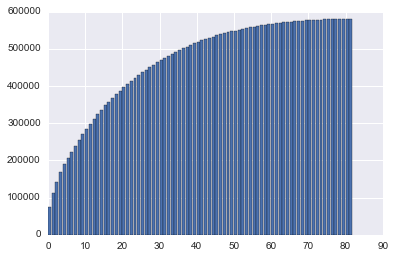

In [61]:
%matplotlib inline
all_importance = [x[1] for x in sorted_feature_importacne]
x = pd.Series(all_importance).sort_values(ascending = False).cumsum()
plt.bar(range(len(x)),x)

In [57]:
config.feature_dict['type_c_pca'] = type_c_pca_feature_list

### find best iteration

In [ ]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats'])
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
trade_tt_mat = np.hstack(feature_sequence_list)
trade_tt_mat[trade_tt_mat==-10]=np.nan

### generating the result using the best model

In [62]:
dir(config)

['__doc__',
 '__module__',
 'data_path',
 'feature_dict',
 'feature_path',
 'model_features',
 'result_path',
 'single_module_validation_indice_set',
 'trade_train_size',
 'train_2_6_index']

In [ ]:
train_X = trade_tt_mat[config.train_2_6_index]
test_X = trade_tt_mat[config.trade_train_size:]
train_y = train_labels

preds, _ = runLGBM(train_X, train_y, test_X, feature_names=features,verbose=100,eta=0.02,
                          early_stop=None,num_rounds=102,watch_dict=result_dict)
